In [13]:
# standard modules
import datetime
import time

# 3rd party modules
import pandas as pd
import numpy as np
import seaborn as sb

# local modules
from libs.CovidTimeseriesModel import CovidTimeseriesModel 
from libs.CovidTimeseriesModelSIR import CovidTimeseriesModelSIR
from libs.datasets import CDSDataset, JHUDataset
from libs.datasets import DHBeds, FIPSPopulation
from libs.datasets.dataset_utils import AggregationLevel

# set vendor defaults
# Pandas: display format for float uses two decimal places
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [14]:
# autoreload reloads modules automatically before entering
# the execution of code typed at the IPython prompt.
# https://ipython.org/ipython-doc/stable/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# import matplotlib and related libraries
%matplotlib inline
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [16]:
timeseries_data = JHUDataset.local().timeseries()
beds_data = DHBeds.local().beds()
population_data = FIPSPopulation.local().population()

In [17]:
def model_state(country, state, interventions=None):
   
    # we should cut this, only used by the get_timeseries function, but probably not needed
    MODEL_INTERVAL = 4

    # Pack all of the assumptions and parameters into a dict that can be passed into the model    
    DATA_PARAMETERS = {
        'timeseries': timeseries_data.get_subset(AggregationLevel.STATE).get_data(country=country, state=state),
        'beds': beds_data.get_state_level(state),
        'population': population_data.get_state_level(country, state)
    }
    
    # define constants used in model parameter calculations
    observed_daily_growth_rate = 1.21
    
    MODEL_PARAMETERS = {        
        #'model': 'seir',
        'model': 'asymp',
        'model_cols': ["total", "susceptible", "exposed", "infected", "asymp", "infected_a", "infected_b", "infected_c", "recovered", "dead",],
        
        'use_harvard_params': False, #If True use the harvard parameters directly, if not calculate off the above
        'fix_r0': False, #If True use the parameters that make R0 2.4, if not calculate off the above
        
        'days_to_model': 270,

        ## Variables for calculating model parameters Hill -> our names/calcs    
        # IncubPeriod: Average incubation period, days - presymptomatic_period
        # DurMildInf: Average duration of mild infections, days - duration_mild_infections
        # FracMild: Average fraction of (symptomatic) infections that are mild - (1 - hospitalization_rate)
        # FracSevere: Average fraction of (symptomatic) infections that are severe - hospitalization_rate * hospitalized_cases_requiring_icu_care
        # FracCritical: Average fraction of (symptomatic) infections that are critical - hospitalization_rate * hospitalized_cases_requiring_icu_care
        # CFR: Case fatality rate (fraction of infections that eventually result in death) - case_fatality_rate
        # DurHosp: Average duration of hospitalization (time to recovery) for individuals with severe infection, days - hospital_time_recovery
        # TimeICUDeath: Average duration of ICU admission (until death or recovery), days - icu_time_death 
        
        # LOGIC ON INITIAL CONDITIONS:
        # hospitalized = case load from timeseries on last day of data / 4
        # mild = hospitalized / hospitalization_rate
        # icu = hospitalized * hospitalized_cases_requiring_icu_care
        # expoosed = exposed_infected_ratio * mild
        
        # Time before exposed are infectious (days)
        'presymptomatic_period': 3, 
        
        # Ratio of asymptomatic, infectious [A] people to
        # infected, mild symptoms [I_1] people (unitless)
        'asymp_to_mild_ratio': 1,

        # Time mildly infected people stay sick before
        # hospitalization or recovery (days)
        'duration_mild_infections': 6, 

        # Time asymptomatically infected people stay
        # infected before recovery (days)
        'duration_asymp_infections': 6, 
        
        # Duration of hospitalization before icu or
        # recovery (days)
        'hospital_time_recovery': 6, 

        # Time from ICU admission to death (days)
        'icu_time_death': 8, 

        ####################################################
        # BETA: transmission rate (new cases per day). 
        # The rate at which infectious cases of various
        # classes cause secondary or new cases.
        ####################################################
        #
        # Transmission rate of infected people with no
        # symptoms [A] (new cases per day)
        # Default: 0.6
        # Current: Calculated based on observed doubling
        # rates
        'beta_asymp': 0.3 + \
            ((observed_daily_growth_rate - 1.09) / 0.02) * \
            0.05,
        #
        # Transmission rate of infected people with mild
        # symptoms [I_1] (new cases per day)
        # Default: 0.6
        # Current: Calculated based on observed doubling
        # rates
        'beta': 0.3 + \
            ((observed_daily_growth_rate - 1.09) / 0.02) * \
            0.05,
        #
        # Transmission rate of infected people with severe
        # symptoms [I_2] (new cases per day)
        # Default: 0.1
        'beta_hospitalized': 0.1,
        #
        # Transmission rate of infected people with severe
        # symptoms [I_3] (new cases per day)
        # Default: 0.1
        'beta_icu': 0.1,
        #
        ####################################################
        
        "hospitalization_rate": 0.0727,
        "hospitalized_cases_requiring_icu_care": 0.1397,
        "case_fatality_rate": 0.0109341104294479,
        
        'exposed_from_infected': True,
        
        'hospital_capacity_change_daily_rate': 1.05,
        'max_hospital_capacity_factor': 2.07,
        'initial_hospital_bed_utilization': .6,     

        'interventions': interventions,
        'observed_daily_growth_rate': observed_daily_growth_rate,
    }
    
    # TODO explain these lines
    # an attempt to define beta based on the observed doubling rate
    # warning: this may be invalid in locations with limited data for doubling rates
    MODEL_PARAMETERS['case_fatality_rate_hospitals_overwhelmed'] = MODEL_PARAMETERS['hospitalization_rate'] * MODEL_PARAMETERS['hospitalized_cases_requiring_icu_care']
    MODEL_PARAMETERS['exposed_infected_ratio'] = 1
    
    MODEL_PARAMETERS.update(DATA_PARAMETERS)
    
    return CovidTimeseriesModelSIR().forecast_region(model_parameters=MODEL_PARAMETERS)

INTERVENTIONS = [None, None, None, None]

In [18]:
def plot_df(df, cols):
    cols.append('date')
    
    df = df.loc[:, cols]
    x_dates = df['date'].dt.strftime('%Y-%m-%d').sort_values().unique()
        
    df.set_index('date', inplace=True)
    
    stacked = df.stack().reset_index()
    
    stacked.columns = ['date', 'Population', 'Number of people']
    
    plt.figure(figsize=(15,8))

    df_plt = sb.lineplot(x='date', y='Number of people', hue='Population', data=stacked, dashes=[(2, 2), (2, 2)])

    #df_plt.set_xticklabels(labels=x_dates, rotation=45, ha='right')

    return(df_plt)

In [19]:
# perform model run
[df, soln] = model_state('USA', 'TX', INTERVENTIONS[0])

         date  infected  recovered   dead       total  exposed  infected_a  \
51 2020-04-04       nan   19109.45 129.56 28995881.00 41480.94    19240.78   
52 2020-04-05       nan   26084.61 149.97 28995881.00 51545.27    23428.06   
53 2020-04-06       nan   34583.73 171.21 28995881.00 63545.28    28662.72   
54 2020-04-07       nan   44976.93 193.55 28995881.00 78074.26    35127.76   
55 2020-04-08       nan   57704.84 217.35 28995881.00 95768.58    43071.85   

    infected_b  infected_c    asymp  infected_tmp  
51     1006.34      149.13 19240.78      39637.03  
52     1089.70      154.50 23428.06      48100.32  
53     1212.86      161.49 28662.72      58699.79  
54     1382.39      170.87 35127.76      71808.78  
55     1606.28      183.44 43071.85      87933.41  


In [20]:
# display outputs - tabular
df.iloc[25:].head(25)

,date,infected,recovered,dead,total,exposed,infected_a,infected_b,infected_c,asymp,susceptible,pct_change,doubling_time,beds
25,2020-03-09,14.00,0.00,0.00,28995881.00,0.00,14.00,0.00,0.00,0.00,28995853.00,nan,nan,73791
26,2020-03-10,13.00,0.00,0.00,28995881.00,0.00,13.00,0.00,0.00,0.00,28995855.00,nan,nan,73791
27,2020-03-11,21.00,0.00,0.00,28995881.00,0.00,21.00,0.00,0.00,0.00,28995839.00,nan,nan,73791
28,2020-03-12,27.00,0.00,0.00,28995881.00,0.00,27.00,0.00,0.00,0.00,28995827.00,nan,nan,73791
29,2020-03-13,43.00,0.00,0.00,28995881.00,0.00,43.00,0.00,0.00,0.00,28995795.00,nan,nan,73791
30,2020-03-14,57.00,0.00,0.00,28995881.00,0.00,57.00,0.00,0.00,0.00,28995767.00,nan,nan,73791
31,2020-03-15,72.00,0.00,0.00,28995881.00,0.00,72.00,0.00,0.00,0.00,28995737.00,nan,nan,73791
32,2020-03-16,85.00,0.00,0.00,28995881.00,0.00,85.00,0.00,0.00,0.00,28995711.00,nan,nan,73791
33,2020-03-17,109.00,0.00,1.00,28995881.00,0.00,109.00,0.00,0.00,0.00,28995662.00,nan,nan,73791
34,2020-03-18,170.00,0.00,3.00,28995881.00,0.00,170.00,0.00,0.00,0.00,28995538.00,nan,nan,73791


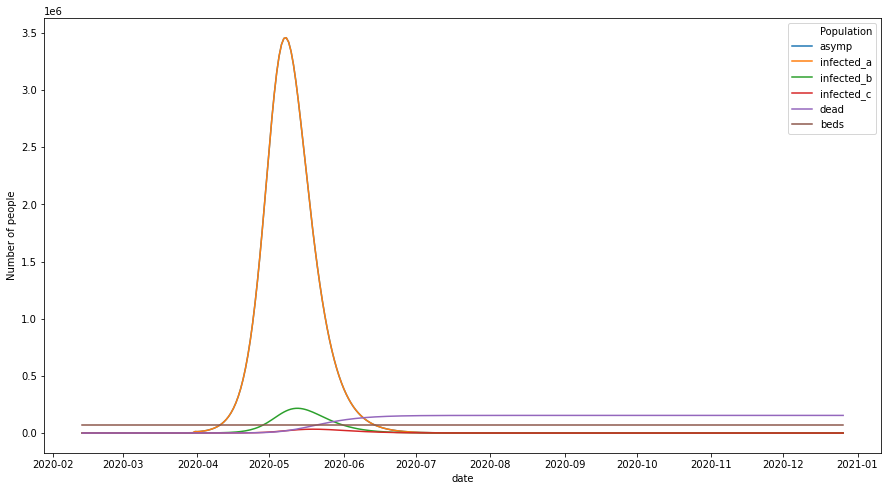

In [21]:
# display outputs - line chart
df['week'] = pd.DatetimeIndex(df['date']).week
chart_cols = ["asymp", "infected_a", "infected_b", "infected_c", "dead", "beds"] #, "susceptible"] "recovered",
plot_df(df, chart_cols)

In [22]:
# calculate doubling time by week
avg_doubling = df.loc[:, ('week', 'doubling_time')].groupby('week').mean()
print('avg doubling time by week')
print(avg_doubling)

avg doubling time by week
      doubling_time
week               
7               nan
8               nan
9               nan
10              nan
11              nan
12              nan
13              nan
14            45.53
15             4.23
16             3.19
17             3.40
18             4.57
19            11.54
20            78.89
21           -13.16
22            -8.54
23            -7.16
24            -6.53
25            -6.18
26            -5.97
27            -5.84
28            -5.75
29            -5.68
30            -5.64
31            -5.61
32            -5.59
33            -5.57
34            -5.56
35            -5.56
36            -5.55
37            -5.55
38            -5.56
39            -5.56
40            -5.57
41            -5.57
42            -5.58
43            -5.59
44            -5.60
45            -5.61
46            -5.62
47            -5.63
48            -5.65
49            -5.66
50            -5.67
51            -5.69
52            -5.69


In [23]:
# perform model run
[intervention_df, soln] = model_state('USA', 'TX', INTERVENTIONS[3])

         date  infected  recovered   dead       total  exposed  infected_a  \
51 2020-04-04       nan   19109.45 129.56 28995881.00 41480.94    19240.78   
52 2020-04-05       nan   26084.61 149.97 28995881.00 51545.27    23428.06   
53 2020-04-06       nan   34583.73 171.21 28995881.00 63545.28    28662.72   
54 2020-04-07       nan   44976.93 193.55 28995881.00 78074.26    35127.76   
55 2020-04-08       nan   57704.84 217.35 28995881.00 95768.58    43071.85   

    infected_b  infected_c    asymp  infected_tmp  
51     1006.34      149.13 19240.78      39637.03  
52     1089.70      154.50 23428.06      48100.32  
53     1212.86      161.49 28662.72      58699.79  
54     1382.39      170.87 35127.76      71808.78  
55     1606.28      183.44 43071.85      87933.41  


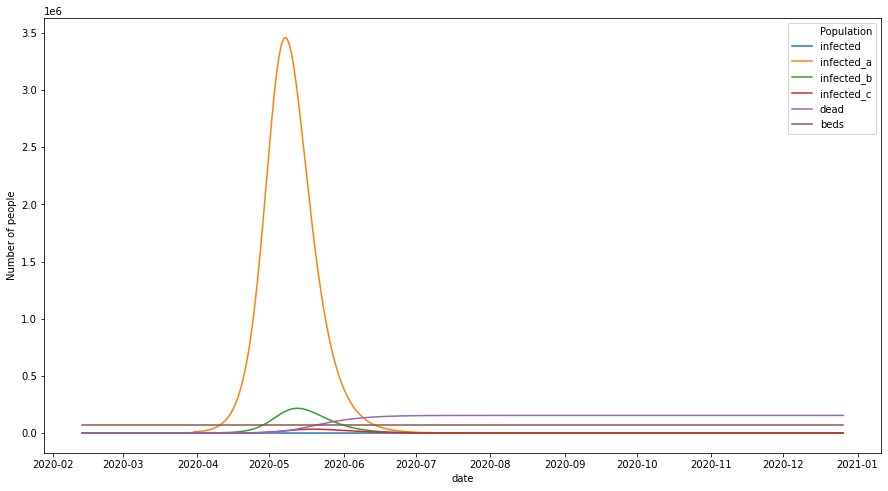

In [38]:
# display outputs - line chart
df['week'] = pd.DatetimeIndex(df['date']).week
chart_cols = ["infected", "infected_a", "infected_b", "infected_c", "dead", "beds"]
plot_df(intervention_df, chart_cols)